**visualizing *k*-means image segmentation in process**

*k*-meanz clustering of ```"Les raboteurs de parquet"``` with *k*=50 over 5 rounds...

>```
$ python k_means_tf.py ~/Downloads/caillebotte_floor_strippers.jpg -k50 -r5 --data_saving=T --generate_all=T
```



INPUT, via Gustave Caillebotte:
![Les raboteurs de parquet](files/imgs/171026_Caillebotte_Floor Strippers.jpg)


In [1]:
%matplotlib inline

import os
import re

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimage
from matplotlib import animation
import numpy as np

In [2]:
# load paths/to/relevant/files

pwd = os.path.abspath('.')
data_dir = os.path.join(pwd, 'data')
img_dir = os.path.join(pwd,'imgs')

# parse directory for centroid, cluster_size datafiles
d_centroids, d_clust_size = {}, {}
filetypes = {'roids': d_centroids, 'cluster_size': d_clust_size}

for ftype, fdict in filetypes.iteritems():
    pattern = re.compile(r'(?P<file>.*[^_]*_(?P<round>.*)\.{}\.txt$)'.format(ftype))
    matches = (re.search(pattern, f) for f in os.listdir(data_dir))
    for m in matches:
        try:
            fdict[m.group('round')] = m.group('file')
        except:
            continue

# ..and dims datafile
pattern = re.compile(r'.*\.dims\.txt$')
matches = (re.search(pattern, f) for f in os.listdir(data_dir))
for m in matches:
    try:
        img_dims = m.group(0)
        break # one file only
    except:
        continue

# ..and corresponding images
d_imgs = {}
pattern = re.compile(r'(?P<file>.*[^_]*_(?P<round>.*)\.jpg$)'.format(ftype))
matches = (re.search(pattern, f) for f in os.listdir(img_dir))
for m in matches:
    try:
        d_imgs[m.group('round')] = m.group('file')
    except:
        continue

In [3]:
# Utils to load data by clustering round

with open(os.path.join(data_dir, img_dims), 'r') as f:
    dims = np.loadtxt(f)

def loadData(r):
    r = str(r)
    with open(os.path.join(data_dir, d_centroids[r]), 'r') as f:
        centroids = np.loadtxt(f)
    
    if r == 'init':
        clust_size = None
    else:
        with open(os.path.join(data_dir, d_clust_size[r]), 'r') as f:
            clust_size = np.loadtxt(f)
    
    centroids_yx, centroids_rgb = centroids[:,:2], centroids[:,2:]
    return (centroids_yx, centroids_rgb, clust_size)


def loadImage(r):
    r = str(r)
    with open(os.path.join(img_dir, d_imgs[r]), 'r') as f:
        return mpimage.imread(f)
    
height, width, ratio = dims

ROUND = '0'

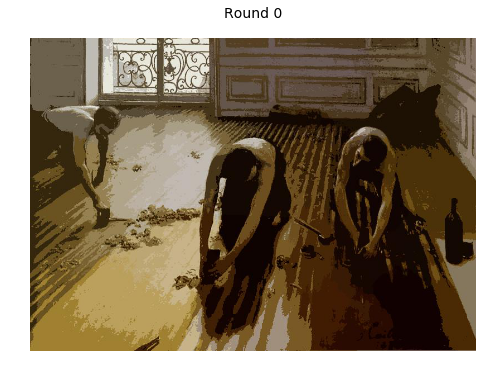

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)

image = loadImage(ROUND)

# scale plot by factor N
N = 1.4
params = plt.gcf()
figDims = fig.get_size_inches()
params.set_size_inches(N*dim for dim in figDims)

ax.set_title('Round {}'.format(ROUND), fontsize=14, y=1.05)

plt.axis("off")
plt.imshow(image)

**@ round 0: where are clusters in colorspace ? pixels per cluster ?**

In [5]:
centroids_yx, centroids_rgb, clust_size = loadData(ROUND)

# unpack centroid color data
R,G,B = [np.array(vals, dtype=np.int32) for vals in zip(*centroids_rgb)]

# normalize RGB to [0,1]
colors = [np.array(pt)/255. for pt in centroids_rgb]

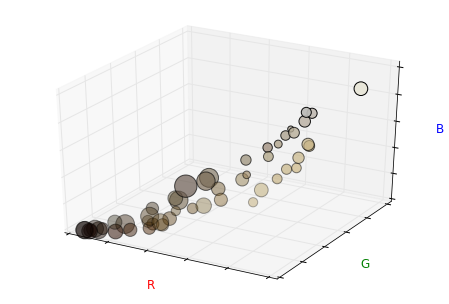

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# set axis ranges for colorspace
colorspace = [0,255]
ax.set_xlim(colorspace)
ax.set_ylim(colorspace)
ax.set_zlim(colorspace)

# set maximum point area
MAX_AREA = 500
r = MAX_AREA/max(clust_size)

# scale plot by factor N
N = 1.3
params = plt.gcf()
figDims = fig.get_size_inches()
params.set_size_inches(N*dim for dim in figDims)

# add figure text
#fig.suptitle('Round {}'.format(ROUND), fontsize=14, fontweight='bold')
ax.set_xlabel('R', color='red', fontsize=12)
ax.set_ylabel('G', color='green', fontsize=12)
ax.set_zlabel('B', color='blue', fontsize=12)

# but remove tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

# add figure text
#ax.set_title('Round {}'.format(ROUND), fontsize=14, y=1.05)

ax.scatter(R, G, zs = B, c = colors, s = r*clust_size)

**... in image space ?**

In [30]:
# unpack centroid location data
y,x = [np.array(vals) for vals in zip(*centroids_yx)]

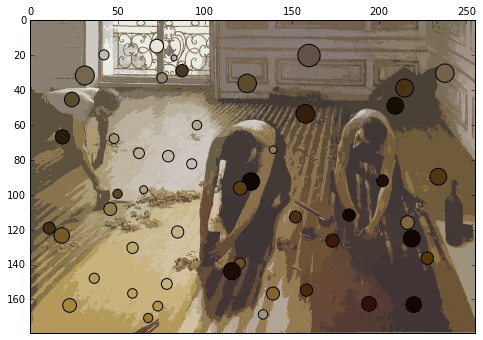

In [31]:
fig = plt.figure()
ax = plt.gca()

# set maximum point radius
MAX_RADIUS = 500
r = MAX_RADIUS/max(clust_size)

ax.scatter(x, y, c = colors, s = r*clust_size)
#ax.scatter(x, y, c = colors)

# scale axes to image size (scaled if clustering scaled)
ax.set_xlim([0,width*ratio])
ax.set_ylim([0,height*ratio])
# set origin to top left, as per image array
ax.invert_yaxis()
ax.xaxis.tick_top()

# scale plot by factor N
N = 1.4
params = plt.gcf()
figDims = fig.get_size_inches()
params.set_size_inches(N*dim for dim in figDims)

# with image
image = loadImage(ROUND)
plt.imshow(image, extent=[0,width*ratio,height*ratio,0], alpha=0.8)

# add figure text
#fig.suptitle('Round {}'.format(ROUND), fontsize=14, y=1.05)

**clustering over 5 rounds = let's make some movies.**

In [32]:
# vid utils

def video_inline(fname, options=['controls','autoplay','loop']):
    """Util to embed videos inline"""
    from IPython.display import HTML
    mimetype = os.path.splitext(fname)[-1].replace('.','')
    video_encoded = open(fname, "rb").read().encode("base64")
    tags = ' '.join(options)
    video_tag = '<video {} src="data:video/{};base64,{}">'.\
                        format(tags, mimetype, video_encoded)
    return HTML(data = video_tag)

def ani2vid(ani, outfile, options=None):
    """Save animation to file and display inline"""
    ani.save(outfile, fps=0.2, writer=animation.FFMpegWriter(),
         extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
    # avoid displaying initial frame below vid
    plt.close(ani._fig)
    return video_inline(outfile, options) if options else video_inline(outfile)

In [33]:
# set up permanent parts of fig
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# set axis ranges for colorspace
colorspace = [0,255]
ax.set_xlim(colorspace)
ax.set_ylim(colorspace)
ax.set_zlim(colorspace)

# set maximum point area
#MAX_AREA = 500
# TODO: make constant ?
#r = MAX_AREA/max(clust_size)
# currently: r is set by previous ratio in example above (ROUND 0: ~0.02)

# scale plot by factor N
N = 1.3
params = plt.gcf()
figDims = fig.get_size_inches()
params.set_size_inches(N*dim for dim in figDims)

# add figure text
#fig.suptitle('Round {}'.format(ROUND), fontsize=14, fontweight='bold')
ax.set_xlabel('R', color='red', fontsize=12)
ax.set_ylabel('G', color='green', fontsize=12)
ax.set_zlabel('B', color='blue', fontsize=12)

# but remove tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

scat = ax.scatter([], [], zs=[], s=[], c=[])

def init():
    # TODO: randomly intialized centroids ?
    #centroids_yx, centroids_rgb, clust_size = loadData('init')
    #data = centroids_rgb
    #R,G,B = [np.array(vals, dtype=np.int32) for vals in zip(*data)]
    # normalize RGB to [0,1]
    #colors = [np.array(pt)/255.0 for pt in data]
    
    #scat._offsets3d = (R, G, B)
    return scat,

# define update function for each round
def update(i):
    _, centroids_rgb, clust_size = loadData(i)
    # get centroid color data
    R,G,B = [np.array(vals, dtype=np.int32) for vals in zip(*centroids_rgb)]
    # normalize RGB to [0,1]
    colors = [np.array(pt)/255. for pt in centroids_rgb]
    # normalize sizes by ratio r
    sizes = r*clust_size
    
    # because of nonsense about changing color on 3D plots,
    # instead reset axis and redraw new scatter each round
    global scat
    scat.remove()
    scat = ax.scatter(R, G, zs=B, c=colors, s=sizes)
    
    # return with commma to make iterable (necessary for blit=True)
    return scat,

OUTFILE = 'ani_rgb.mp4'
ani = animation.FuncAnimation(fig, update, init_func=init,
                              frames=5, interval=100000, blit=True,
                              repeat=True, repeat_delay=5000)
ani2vid(ani, OUTFILE)

In [1006]:
# set up new fig
fig = plt.figure()
ax = plt.gca()

# set maximum point radius
#MAX_RADIUS = 500
#r = MAX_RADIUS/max(clust_size)

# scale axes to image size (scaled if clustering scaled)
ax.set_xlim([0,width*ratio])
ax.set_ylim([0,height*ratio])
# set origin to top left, as per image array
ax.invert_yaxis()
ax.xaxis.tick_top()

# scale plot by factor N
N = 1.3
params = plt.gcf()
figDims = fig.get_size_inches()
params.set_size_inches(N*dim for dim in figDims)

scat = ax.scatter([], [])

def init():
    return scat,

def update(i):
    centroids_yx, centroids_rgb, clust_size = loadData(i)
    
    # get centroid location data
    y,x = [np.array(vals) for vals in zip(*centroids_yx)]
    # get centroid color data
    R,G,B = [np.array(vals, dtype=np.int32) for vals in zip(*centroids_rgb)]
    # normalize RGB to [0,1]
    colors = [np.array(pt)/255. for pt in centroids_rgb]
    # normalize sizes by ratio r
    sizes = r*clust_size

    global scat
    scat.remove()
    scat = ax.scatter(x, y, c=colors, s=sizes)
    
    return scat,


OUTFILE = 'ani_xy.mp4'
ani = animation.FuncAnimation(fig, update, init_func=init, #fargs=(scat),
                              frames=5, interval=100000, blit=True,
                              repeat=True, repeat_delay=5000)
ani2vid(ani, OUTFILE)

In [34]:
# set up new fig
fig = plt.figure()
ax = plt.gca()

# scale plot by factor N
N = 1.5
params = plt.gcf()
figDims = fig.get_size_inches()
params.set_size_inches(N*dim for dim in figDims)

# hide axis
plt.axis("off")

# add figure text
title = ax.set_title('', fontsize=14, y=1.05)

im = plt.imshow(np.empty_like(loadImage(ROUND)))

def init():
    return im,

def update(i):
    image = loadImage(i)
    im.set_array(image)
    title.set_text('Round {}'.format(i))
    return im,title

OUTFILE='ani_imgs.mp4'
ani = animation.FuncAnimation(fig, update, init_func=init,
                              frames=5, interval=1000, blit=True,
                              repeat=True, repeat_delay=500000, save_count=10000000000)
ani2vid(ani, OUTFILE, ['controls', 'autoplay'])

In [35]:
# all together now: centroid locations, overlaid on image, with round #

# set up new fig
fig = plt.figure()
ax = plt.gca()

# set maximum point radius
#MAX_RADIUS = 500
#r = MAX_RADIUS/max(clust_size)

# scale axes to image size (scaled if clustering scaled)
ax.set_xlim([0,width*ratio])
ax.set_ylim([0,height*ratio])
# set origin to top left, as per image array
ax.invert_yaxis()
ax.xaxis.tick_top()

# scale plot by factor N
N = 2.0
params = plt.gcf()
figDims = fig.get_size_inches()
params.set_size_inches(N*dim for dim in figDims)

scat = ax.scatter([], [])
im = plt.imshow(np.empty_like(loadImage(ROUND)),
                extent=[0,width*ratio,height*ratio,0],
                alpha=0.95)
#title = ax.set_title('', fontsize=14, y=1.05)

def init():
    return scat,im#,title

def update(i):
    centroids_yx, centroids_rgb, clust_size = loadData(i)
    
    # get centroid location data
    y,x = [np.array(vals) for vals in zip(*centroids_yx)]
    # get centroid color data
    R,G,B = [np.array(vals, dtype=np.int32) for vals in zip(*centroids_rgb)]
    # normalize RGB to [0,1]
    colors = [np.array(pt)/255. for pt in centroids_rgb]
    # normalize sizes by ratio r
    sizes = r*clust_size

    global scat
    scat.remove()
    scat = ax.scatter(x, y, c=colors, s=sizes)
    
    im.set_array(loadImage(i))
    
    #title.set_text('Round {}'.format(i))
    
    return scat,im#,title


OUTFILE = 'ani_xy_img.mp4'
ani = animation.FuncAnimation(fig, update, init_func=init, #fargs=(scat),
                              frames=5, interval=100000, blit=True,
                              repeat=True, repeat_delay=5000)
ani2vid(ani, OUTFILE)